In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

d = mnist.data  
l = mnist.target  

df = pd.DataFrame(d)
df['label'] = l  

print(df.head(4))

from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler().fit_transform(df)
print(standardized_data.shape)

data_1000 = standardized_data[0:1000, :]
labels_1000 = l[0:1000]

model = TSNE(n_components = 2, random_state = 0)

tsne_data = model.fit_transform(data_1000)

tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))

sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label', palette="bright")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
data = {
    'Height': [170, 165, 180, 175, 160, 172, 168, 177, 162, 158],
    'Weight': [65, 59, 75, 68, 55, 70, 62, 74, 58, 54],
    'Age': [30, 25, 35, 28, 22, 32, 27, 33, 24, 21],
    'Gender': [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]  # 1 = Male, 0 = Female
}
df = pd.DataFrame(data)
print(df)
X = df.drop('Gender', axis=1)
y = df['Gender']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_numeric = pd.factorize(y)[0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Original Feature 1')
plt.ylabel('Original Feature 2')
plt.title('Before PCA: Using First 2 Standardized Features')
plt.colorbar(label='Target classes')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('After PCA: Projected onto 2 Principal Components')
plt.colorbar(label='Target classes')

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os # For managing the file path


np.random.seed(42)

# 1. Define constants
N_SAMPLES = 50  # 50 patients
N_GENES = 100   # 100 gene expression features

# 2. Create sample labels (Groups: 0 = Control, 1 = Disease)
# We make a slightly unbalanced dataset
groups = np.array([0] * 30 + [1] * 20)
np.random.shuffle(groups)

# 3. Create Gene Expression Data (Features)
# Introduce a subtle difference between the two groups to make PCA meaningful

# Base noise data (all samples are slightly different)
X_base = np.random.randn(N_SAMPLES, N_GENES) * 0.5

# Add a signal bias for the 'Disease' group (Group 1) in the first 5 genes
# These 5 genes are the "informative" ones
signal_genes_indices = np.arange(5)
for i, gene_idx in enumerate(signal_genes_indices):
    # Add a strong expression signal to the 'Disease' group
    X_base[groups == 1, gene_idx] += (i + 1) * 1.5
    # Add a moderate inverse signal to the 'Control' group
    X_base[groups == 0, gene_idx] -= (i + 1) * 0.5

# 4. Create DataFrame and save the CSV
df_features = pd.DataFrame(X_base, columns=[f'Gene_{i+1}' for i in range(N_GENES)])
df_features.insert(0, 'Patient_ID', [f'P{i+1:02d}' for i in range(N_SAMPLES)])
df_features.insert(1, 'Group', groups)
df_features.insert(2, 'Age', np.random.randint(20, 80, N_SAMPLES)) # Additional clinical feature

FILE_NAME = 'bio_mock_data.csv'
df_features.to_csv(FILE_NAME, index=False)
print(f"Mock data saved successfully to '{FILE_NAME}'. Shape: {df_features.shape}")

# --- PART 2: PCA DEMONSTRATION (Using the Saved CSV) ---------------------------



Mock data saved successfully to 'bio_mock_data.csv'. Shape: (50, 103)



Loading data from 'bio_mock_data.csv' for PCA...
Variance Explained by PC1: 0.07
Variance Explained by PC2: 0.05
Total Variance Explained by 2 PCs: 0.12


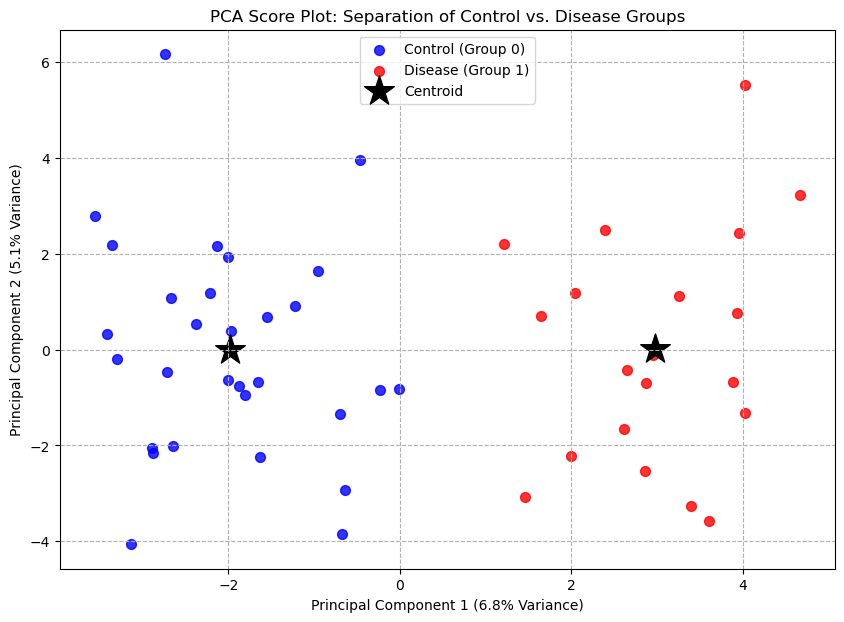


--- Key Finding (Based on Engineered Data) ---
Top 5 Genes Driving Group Separation (Highest Loadings on PC1):
['Gene_5', 'Gene_3', 'Gene_4', 'Gene_2', 'Gene_1']

Interpretation: Genes 1-5 were intentionally given a strong signal during data creation, and PCA successfully identified them as the most important drivers (highest loadings) separating the groups along the PC1 axis.


In [2]:
# 1. Load the data
print(f"\nLoading data from '{FILE_NAME}' for PCA...")
df = pd.read_csv(FILE_NAME)

# 2. Separate Features (Genes) and Labels (Group)
features = [col for col in df.columns if col.startswith('Gene_')]
X = df[features].values
y = df['Group']
patient_ids = df['Patient_ID']

# 3. Feature Scaling
# Get only the gene expression data for scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Combine PC scores with the original labels and IDs
df_final = pd.concat([df_pca, y, patient_ids], axis=1)

# 5. Explaining the Variance
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Variance Explained by PC1: {explained_variance_ratio[0]:.2f}")
print(f"Variance Explained by PC2: {explained_variance_ratio[1]:.2f}")
print(f"Total Variance Explained by 2 PCs: {explained_variance_ratio.sum():.2f}")

# 6. Visualization: PCA Score Plot
plt.figure(figsize=(10, 7))

groups = df_final['Group'].unique()
group_names = {0: 'Control (Group 0)', 1: 'Disease (Group 1)'}
colors = {0: 'blue', 1: 'red'}

for group in groups:
    indices_to_keep = df_final['Group'] == group
    plt.scatter(
        df_final.loc[indices_to_keep, 'PC1'],
        df_final.loc[indices_to_keep, 'PC2'],
        c=colors[group],
        s=50,
        alpha=0.8,
        label=group_names[group]
    )

# Add centroids for visual clarity
centroid_pc1 = df_final.groupby('Group')['PC1'].mean()
centroid_pc2 = df_final.groupby('Group')['PC2'].mean()
plt.scatter(
    centroid_pc1, centroid_pc2, 
    marker='*', s=500, c='k', 
    label='Centroid'
)

plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]*100:.1f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]*100:.1f}% Variance)')
plt.title('PCA Score Plot: Separation of Control vs. Disease Groups')
plt.legend()
plt.grid(linestyle='--')
plt.show()

# 7. Interpretation of Loadings (Biomarker Discovery)
loadings_pc1 = pd.Series(pca.components_[0], index=features)

# The top 5 genes contributing most to PC1 (highest absolute loading)
top_genes_pc1 = loadings_pc1.abs().sort_values(ascending=False).head(5)

print("\n--- Key Finding (Based on Engineered Data) ---")
print("Top 5 Genes Driving Group Separation (Highest Loadings on PC1):")
print(top_genes_pc1.index.tolist()) 
print("\nInterpretation: Genes 1-5 were intentionally given a strong signal during data creation, and PCA successfully identified them as the most important drivers (highest loadings) separating the groups along the PC1 axis.")